# 1.载入读取数据

cornell的数据下载后是7个压缩包，如下所示：

In [1]:
import os
os.chdir('/home/ldh/Documents/github_repository/cornell_dataset/cornell')

In [16]:
os.listdir()

['data07.tar.gz',
 'data02.tar.gz',
 'data06.tar.gz',
 'data01.tar.gz',
 'data04.tar.gz',
 'data05.tar.gz',
 'data03.tar.gz']

解压操作可以手动完成，无需编程，完后得到这些文件（外加一个背景图片）

In [2]:
data = os.listdir()
data.sort()
print('\n'.join(data))

01
02
03
04
05
06
07
08
09
10
backgrounds
data01.tar.gz
data02.tar.gz
data03.tar.gz
data04.tar.gz
data05.tar.gz
data06.tar.gz
data07.tar.gz


查看每个文件夹下的内容：

In [3]:
os.chdir('01')

In [4]:
os.listdir()

['pcd0199r.png',
 'pcd0175r.png',
 'pcd0190d.tiff',
 'pcd0191cpos.txt',
 'pcd0183.txt',
 'pcd0104.txt',
 'pcd0122.txt',
 'pcd0110d.tiff',
 'pcd0173d.tiff',
 'pcd0111.txt',
 'pcd0175.txt',
 'pcd0143d.tiff',
 'pcd0118r.png',
 'pcd0140r.png',
 'pcd0119.txt',
 'pcd0132.txt',
 'pcd0171r.png',
 'pcd0124cneg.txt',
 'pcd0105cpos.txt',
 'pcd0181cpos.txt',
 'pcd0131cneg.txt',
 'pcd0157.txt',
 'pcd0141cpos.txt',
 'pcd0115cneg.txt',
 'pcd0158.txt',
 'pcd0133.txt',
 'pcd0149cneg.txt',
 'pcd0139.txt',
 'pcd0145cpos.txt',
 'pcd0150cpos.txt',
 'pcd0151cneg.txt',
 'pcd0144d.tiff',
 'pcd0185cpos.txt',
 'pcd0136.txt',
 'pcd0127cpos.txt',
 'pcd0110r.png',
 'pcd0140d.tiff',
 'pcd0119cpos.txt',
 'pcd0119r.png',
 'pcd0197r.png',
 'pcd0102cneg.txt',
 'pcd0144cpos.txt',
 'pcd0191r.png',
 'pcd0110cneg.txt',
 'pcd0182.txt',
 'pcd0161cneg.txt',
 'pcd0130.txt',
 'pcd0195cneg.txt',
 'pcd0134cpos.txt',
 'pcd0162cneg.txt',
 'pcd0138d.tiff',
 'pcd0179cpos.txt',
 'pcd0138.txt',
 'pcd0159cneg.txt',
 'pcd0174r.png',
 'pc

可以看到，文件共有5种，分别是：
- pcd****.txt     :样本对应的点云文件
- pcd****cneg.txt :样本的失败抓取框标注
- pcd****cpos.txt :样本的正确抓取标注
- pcd****r.png    :样本的RGB图像
- pcd****d.tiff   :由点云生成的样本深度图像（数据集中本不包含，自己写程序生成）

初步的操作计划先不管点云，围绕RGB和Depth图像和抓取框标注展开，先对其进行可视化

In [5]:
os.chdir('/home/ldh/Documents/github_repository/cornell_dataset')

In [6]:
import glob

使用glob模块来解析所有的目标数据路径：

The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell, although results are returned in arbitrary order. 

glob模块可以检索出所有符合特定路径格式要求（按照unix 命令行规则）的路径名，但是返回的结果顺序是随机的

详见：https://docs.python.org/3/library/glob.html

In [7]:
help(glob.glob)

Help on function glob in module glob:

glob(pathname, *, recursive=False)
    Return a list of paths matching a pathname pattern.
    
    The pattern may contain simple shell-style wildcards a la
    fnmatch. However, unlike fnmatch, filenames starting with a
    dot are special cases that are not matched by '*' and '?'
    patterns.
    
    If recursive is true, the pattern '**' will match any files and
    zero or more directories and subdirectories.



In [8]:
cornell_path = 'cornell'
graspf = glob.glob(os.path.join(cornell_path,'*','pcd*cpos.txt'))
graspf.sort()

In [9]:
help(os.path.join)#注意此join非彼join，是os.path模块里面自带的构造文件路径的函数

Help on function join in module posixpath:

join(a, *p)
    Join two or more pathname components, inserting '/' as needed.
    If any component is an absolute path, all previous path components
    will be discarded.  An empty last part will result in a path that
    ends with a separator.



In [10]:
graspf[0:10]

['cornell/01/pcd0100cpos.txt',
 'cornell/01/pcd0101cpos.txt',
 'cornell/01/pcd0102cpos.txt',
 'cornell/01/pcd0103cpos.txt',
 'cornell/01/pcd0104cpos.txt',
 'cornell/01/pcd0105cpos.txt',
 'cornell/01/pcd0106cpos.txt',
 'cornell/01/pcd0107cpos.txt',
 'cornell/01/pcd0108cpos.txt',
 'cornell/01/pcd0109cpos.txt']

用这种方式来查找读取文件的好处非常明显，跟cd到指定目录然后listdir相比，这种可以直接返回完整的文件路径，而不需要再进行构造。

之前也看到了，这数据的格式命名都很有规律，所以可以根据这个抓取文件的路径名来构造其他的文件名

In [11]:
rgbf = [filename.replace('cpos.txt','r.png') for filename in graspf]
depthf = [filename.replace('cpos.txt','d.tiff') for filename in graspf]

In [12]:
print('\n'.join(rgbf[0:10]))
print('\n'.join(depthf[0:10]))

cornell/01/pcd0100r.png
cornell/01/pcd0101r.png
cornell/01/pcd0102r.png
cornell/01/pcd0103r.png
cornell/01/pcd0104r.png
cornell/01/pcd0105r.png
cornell/01/pcd0106r.png
cornell/01/pcd0107r.png
cornell/01/pcd0108r.png
cornell/01/pcd0109r.png
cornell/01/pcd0100d.tiff
cornell/01/pcd0101d.tiff
cornell/01/pcd0102d.tiff
cornell/01/pcd0103d.tiff
cornell/01/pcd0104d.tiff
cornell/01/pcd0105d.tiff
cornell/01/pcd0106d.tiff
cornell/01/pcd0107d.tiff
cornell/01/pcd0108d.tiff
cornell/01/pcd0109d.tiff


可视化一下来看看效果

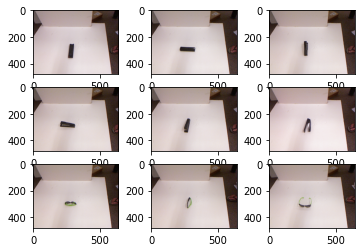

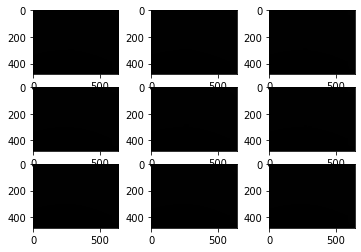

In [13]:
from PIL import Image
import matplotlib.pyplot as plt

for i in range(9):
    img = Image.open(rgbf[i])
    plt.subplot(331+i)
    plt.imshow(img)
plt.show()

for i in range(9):
    img = Image.open(depthf[i])
    plt.subplot(331+i)
    plt.imshow(img)
plt.show()

图片正常显示，说明文件路径无误。

# 2.对数据进行处理
## 2.1可视化抓取框标注

In [14]:
#先打开一个文件看一下怎么存的
with open(graspf[0],'r') as f:
    grasp_data = f.read()

In [15]:
print(grasp_data)

253 319.7 
309 324 
307 350 
251 345.7
255 324.877 
308 332 
313 295 
260 287.877
260 303.092 
311 309 
314 283 
263 277.092
258 279.048 
320 282 
321 261 
259 258.048



我记得之前的帮助文件里面写了，这个里面就是点的坐标，每一行就是一个点，每四个点就是一个抓取矩形。

因为它按行区分，所以换个读取函数，按行读取比较好

In [16]:
with open(graspf[0],'r') as f:
    grasp_data = f.readlines()

In [17]:
grasp_data

['253 319.7 \n',
 '309 324 \n',
 '307 350 \n',
 '251 345.7\n',
 '255 324.877 \n',
 '308 332 \n',
 '313 295 \n',
 '260 287.877\n',
 '260 303.092 \n',
 '311 309 \n',
 '314 283 \n',
 '263 277.092\n',
 '258 279.048 \n',
 '320 282 \n',
 '321 261 \n',
 '259 258.048\n']

In [18]:
grasp_data = [grasp.strip() for grasp in grasp_data]#去除末尾换行符

In [19]:
grasp_data

['253 319.7',
 '309 324',
 '307 350',
 '251 345.7',
 '255 324.877',
 '308 332',
 '313 295',
 '260 287.877',
 '260 303.092',
 '311 309',
 '314 283',
 '263 277.092',
 '258 279.048',
 '320 282',
 '321 261',
 '259 258.048']

接下来要从里面把框的数据读出来并按照一个框一个框的格式区分

In [20]:

def str2num(point):
    '''
    :参数  :point,字符串，以字符串形式存储的一个点的坐标
    :返回值 :列表，包含int型抓取点数据的列表[x,y]
    
    '''
    x,y = point.split()
    x,y = int(round(float(x))),int(round(float(y)))
    
    return (x,y)

def get_rectangle(cornell_grasp_file):
    '''
    :参数  :cornell_grap_file:字符串，指向某个抓取文件的路径
    :返回值 :列表，包含各个抓取矩形数据的列表
    
    '''
    grasp_rectangles = []
    with open(cornell_grasp_file,'r') as f:
        while True:
            grasp_rectangle = []
            point0 = f.readline().strip()
            if not point0:
                break
            point1,point2,point3 = f.readline().strip(),f.readline().strip(),f.readline().strip()
            grasp_rectangle = [str2num(point0),
                               str2num(point1),
                               str2num(point2),
                               str2num(point3)]
            grasp_rectangles.append(grasp_rectangle)
    
    return grasp_rectangles

In [21]:
grs = get_rectangle(graspf[0])

In [22]:
grs

[[(253, 320), (309, 324), (307, 350), (251, 346)],
 [(255, 325), (308, 332), (313, 295), (260, 288)],
 [(260, 303), (311, 309), (314, 283), (263, 277)],
 [(258, 279), (320, 282), (321, 261), (259, 258)]]

因为matplotlib只能画这种竖直的矩形：
:                +------------------+
:                |                  |
:              height               |
:                |                  |
:               (xy)---- width -----+

In [32]:
import cv2

In [33]:
img = cv2.imread(rgbf[0])

In [34]:
for gr in grs:
    for i in range(3):
        img = cv2.line(img,gr[i],gr[i+1],5)
    img = cv2.line(img,gr[3],gr[0],5) 

In [36]:
cv2.imshow('img',img)
cv2.waitKey(10000)

-1

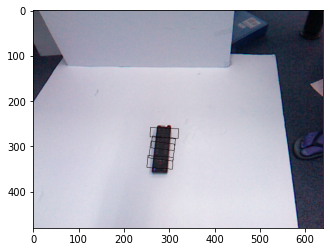

In [37]:
plt.imshow(img)
plt.show()

## 完整程序如下：


In [1]:
import os
import glob
import cv2
import random


cornell_path = "cornell"
graspf = glob.glob(os.path.join(cornell_path,'*','pcd*cpos.txt'))
graspf.sort()

rgbf = [filename.replace('cpos.txt','r.png') for filename in graspf]
depthf = [filename.replace('cpos.txt','d.tiff') for filename in graspf]

def str2num(point):
    '''
    :功能  :将字符串类型存储的抓取框脚点坐标取整并以元组形式返回
    
    :参数  :point,字符串，以字符串形式存储的一个点的坐标
    :返回值 :列表，包含int型抓取点数据的列表[x,y]
    '''
    x,y = point.split()
    x,y = int(round(float(x))),int(round(float(y)))
    
    return (x,y)

def get_rectangles(cornell_grasp_file):
    '''
    :功能  :从抓取文件中提取抓取框的坐标信息
    
    :参数  :cornell_grap_file:字符串，指向某个抓取文件的路径
    :返回值 :列表，包含各个抓取矩形数据的列表
    '''
    grasp_rectangles = []
    with open(cornell_grasp_file,'r') as f:
        while True:
            grasp_rectangle = []
            point0 = f.readline().strip()
            if not point0:
                break
            point1,point2,point3 = f.readline().strip(),f.readline().strip(),f.readline().strip()
            grasp_rectangle = [str2num(point0),
                               str2num(point1),
                               str2num(point2),
                               str2num(point3)]
            grasp_rectangles.append(grasp_rectangle)
    
    return grasp_rectangles

def draw_rectangles(img_path,grasp_path):
    '''
    :功能  :在指定的图片上绘制添加相应的抓取标注框
    
    :参数  :img_path:字符串，指向某个RGB图片的路径
    :参数  :grasp_path:字符串，指向某个抓取文件的路径
    :返回值 :numpy数组，已经添加完抓取框的img数组
    '''
    img_path = img_path
    grasp_path = grasp_path
    
    img = cv2.imread(img_path)
    grs = get_rectangles(grasp_path)
    
    for gr in grs:
        #产生随机颜色
        color = (random.randint(0,255),random.randint(0,255),random.randint(0,255))
        #绘制添加矩形框
        for i in range(3): #因为一个框只有四条线，所以这里是3
            img = cv2.line(img,gr[i],gr[i+1],color,2)
        img = cv2.line(img,gr[3],gr[0],color,2) #补上最后一条封闭的线
    
    cv2.imshow('img',img)
    cv2.waitKey(1000)
    
    return img

if __name__ == "__main__":
    img = draw_rectangles(rgbf[500],graspf[500])
#jupyter好像用不了 parser，所以这里就没用